In [14]:
from src.ALMApy import get_k2_vs_radius
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from scipy.optimize import curve_fit, root_scalar


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Serif"
})

In [15]:
G = 6.67e-11

# Dimensions
R_jupiter = 69.9e6

m_neptune = 1.024e26
R_neptune = 24.6e6
rho_neptune = m_neptune/(4*np.pi/3*R_neptune**3)

R_earth = 6378e3
M_earth = 5.972e24
rho_earth = M_earth/(4*np.pi/3*R_earth**3)

# Material properties
rho_air = 1.293
rigidity_air = 1e-7
viscosity_air = 3e-5
rigidity_earth = 1e11
viscosity_earth = 1e21

In [16]:
R_core = R_earth
rho_core = rho_earth
mu_core = rigidity_earth
eta_core = viscosity_earth
rho_atm = rho_air

max_atm_radius = 3*R_jupiter
no_atm_radii = 100
atmosphere_radii = np.logspace(-3, np.log10((max_atm_radius-R_core)/R_jupiter), no_atm_radii)*R_jupiter + R_core

k2 = get_k2_vs_radius(R_core, atmosphere_radii, [rho_atm, rho_core], [rigidity_air, mu_core], [viscosity_air, eta_core])

The $k_2 R^5$ plot resembles this function:
$$
y=y_0-y_\infty\left[1-\left(1+\left(\frac{x}{x_1}\right)^{\sqrt{a_1b_1}}\right)^{\sqrt{\frac{a_1}{b_1}}}\left(1+\left(\frac{x}{x_2}\right)^{\sqrt{(a_1-a_2)b_2}}\right)^{-\sqrt{\frac{(a_1-a_2)}{b_2}}}\right].
$$
with $x_1<x2$. In the limit where $x\ll x_1$ we have
$$
\lim_{x\ll x_1} y = y_0
$$
In the right hand limit we have
$$
\lim_{x\gg x_2} y = y_0 - y_\infty + y_\infty \frac{x^{a_2}}{x_1^{a_1}x_2^{a_2-a_1}}\approx \frac{y_\infty}{x_1^{a_1}x_2^{a_2-a_1}}x^{a_2}
$$
so this resembles a power-law $y=y_\infty x^{a_2}$ in case we set
$$
\frac{1}{x_1^{a_1}x_2^{a_2-a_1}}=1
$$
from which we get
$$
a_1=-a_2\frac{\log{x_2}}{\log{\left(x_1/x_2\right)}}.
$$
So then we have a function that approaches $y=y_0$ on the left, and $y=y_\infty x^{a_2}$ on the right with two cross-over points at $x_1$ and $x_2$. 

In [31]:
def k2_func(x, k2_core, x1, x2, b1, b2):
    a2 = 5
    a1 = -a2*np.log(x2)/np.log(x1/x2)
    return k2_core - 3/2 + 3/2*(1+(x/x1)**np.sqrt(a1*b1))**np.sqrt(a1/b1)*(1+(x/x2)**np.sqrt((a1-a2)*b2))**(-np.sqrt((a1-a2)/b2))

def log_k2_func(x, k2_core, x1, x2, b1, b2):
    return np.log(k2_func(x, k2_core, x1, x2, b1, b2))

def get_k2_core(R_core, mu_core, rho_core):
    g_core = 4*np.pi/3*G*rho_core*R_core
    return 3/(2*(1+19*mu_core/(2*g_core*rho_core*R_core)))

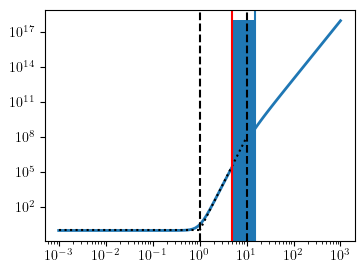

In [93]:
def y(x,x1,x2,a1,a2,w1,w2):
    return (1+(x/x1)**np.sqrt(a1*w1))**np.sqrt(a1/w1)*(1+(x/x2)**np.sqrt((a1-a2)*w2))**(-np.sqrt((a1-a2)/w2))

x_min = 1e-3
x_max = 1e3
x1 = 1
x2 = 10
a1 = 8
a2 = 5
w1 = 3
w2 = 2

fig, ax = plt.subplots(figsize=(4,3))
x = np.logspace(np.log10(x_min),np.log10(x_max),100)
ax.plot(x, y(x,x1,x2,a1,a2,w1,w2), linewidth=2)

x0_interp = np.logspace(np.log10(x_min), np.log10(x1), 100)
ax.plot(x0_interp, 1+x0_interp*0, linestyle='dotted', color='black')

x1_interp = np.logspace(np.log10(x1), np.log10(x2), 100)
ax.plot(x1_interp, (x1_interp/x1)**a1, linestyle='dotted', color='black')
ax.axvline(x2*(1+1/w2))
ax.axvline(x2*(1-1/w2), color="red")
ax.fill_betweenx(ax.get_ylim(), x2*(1-1/w2), x2*(1+1/w2))

ax.set_xscale("log")
ax.set_yscale("log")
ax.axvline(x1, color="black", linestyle="--")
ax.axvline(x2, color="black", linestyle="--")



[ 0.39944827  3.18685191 21.96531249  7.90870719  2.99183469]


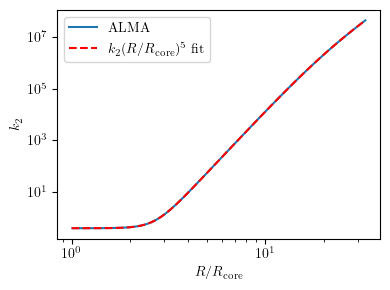

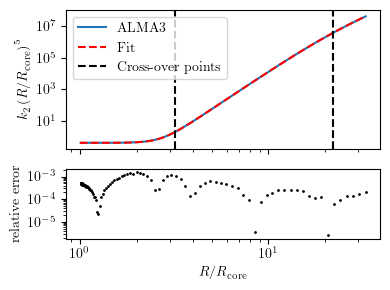

In [102]:


R_interp = np.logspace(0,np.log10(max_atm_radius/R_core),100)
popt,pcov = curve_fit(log_k2_func, atmosphere_radii/R_core, np.log(k2*(atmosphere_radii/R_core)**5), p0=[0.399, 3.37, 20, 10, 2])
print(popt)
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(atmosphere_radii/R_core, k2*(atmosphere_radii/R_core)**5, label="ALMA")
ax.plot(R_interp, k2_func(R_interp, *popt), color="red", linestyle="--", label=r"$k_2(R/R_\mathrm{core})^5$ fit")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$R/R_\mathrm{core}$")
ax.set_ylabel("$k_2$")
ax.legend()
fig.tight_layout()


fig, (ax,err_ax) = plt.subplots(figsize=(4,3), nrows=2, sharex=True, height_ratios=(2,1))
ax.plot(atmosphere_radii/R_core, k2*(atmosphere_radii/R_core)**5, label="ALMA3")
ax.plot(R_interp, k2_func(R_interp, *popt), color="red", linestyle="--", label=r"Fit")
ax.axvline(popt[1], linestyle="dashed", color="black", label="Cross-over points")
ax.axvline(popt[2], linestyle="dashed", color="black")
err_ax.scatter(atmosphere_radii/R_core, np.sqrt(((k2*(atmosphere_radii/R_core)**5 - k2_func(atmosphere_radii/R_core, *popt))/(k2*(atmosphere_radii/R_core)**5))**2), color="black", s=1, label="error")
ax.set_xscale("log")
ax.set_yscale("log")
err_ax.set_xscale("log")
err_ax.set_yscale("log")
err_ax.set_ylabel("relative error")
err_ax.set_xlabel(r"$R/R_\mathrm{core}$")
ax.set_ylabel(r"$k_2\left(R/R_\mathrm{core}\right)^5$")
ax.legend()
fig.tight_layout()
fig.savefig("figures/report/fit_single.pdf")
plt.show()

[ 0.39944827  3.18685191 21.96531249  7.90870719  2.99183469]


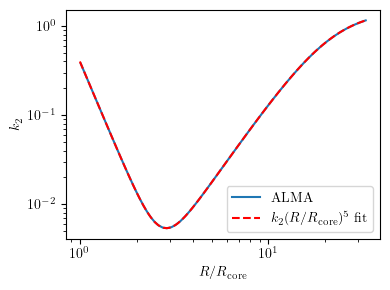

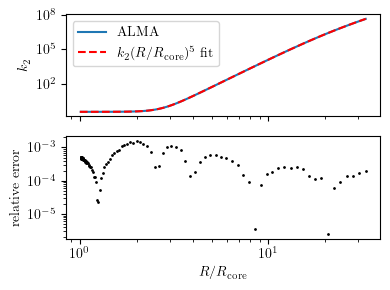

In [ ]:


R_interp = np.logspace(0,np.log10(max_atm_radius/R_core),100)
popt,pcov = curve_fit(log_k2_func, atmosphere_radii/R_core, np.log(k2*(atmosphere_radii/R_core)**5), p0=[0.399, 3.37, 20, 10, 2])
print(popt)
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(atmosphere_radii/R_core, k2, label="ALMA")
ax.plot(R_interp, k2_func(R_interp, *popt)/(R_interp**5), color="red", linestyle="--", label=r"$k_2(R/R_\mathrm{core})^5$ fit")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$R/R_\mathrm{core}$")
ax.set_ylabel("$k_2$")
ax.legend()
fig.tight_layout()


fig, (ax,err_ax) = plt.subplots(figsize=(4,3), nrows=2, sharex=True)
ax.plot(atmosphere_radii/R_core, k2*(atmosphere_radii/R_core)**5, label="ALMA")
ax.plot(R_interp, k2_func(R_interp, *popt), color="red", linestyle="--", label=r"$k_2(R/R_\mathrm{core})^5$ fit")
err_ax.scatter(atmosphere_radii/R_core, np.sqrt(((k2*(atmosphere_radii/R_core)**5 - k2_func(atmosphere_radii/R_core, *popt))/(k2*(atmosphere_radii/R_core)**5))**2), color="black", s=1, label="error")
ax.set_xscale("log")
ax.set_yscale("log")
err_ax.set_xscale("log")
err_ax.set_yscale("log")
err_ax.set_ylabel("relative error")
err_ax.set_xlabel(r"$R/R_\mathrm{core}$")
ax.set_ylabel("$k_2$")
ax.legend()
fig.tight_layout()
plt.show()

### Varying $R_\mathrm{core}$

In [46]:
data_file = "super_earth"
data = np.load("data/"+data_file+".npz", allow_pickle=True)
data = data["data"]


no_atm_radii = 100
#log_max_atm_radius = 1 #maximum radius = 10**log_max_atm_radius * R_jupiter
max_atm_radius = R_jupiter*3

no_core_radii = 10
min_core_radius = 0.5*R_earth
max_core_radius = 2*R_earth
core_radii = np.linspace(min_core_radius, max_core_radius, no_core_radii)
R_min = np.zeros(no_core_radii)

[ 3.18793732 21.96117223  7.87402548  2.99883991]
[ 3.18779964 21.95498701  7.87004959  2.99223088]
[ 3.18769597 21.95279915  7.86468356  2.98934643]
[ 3.18763747 21.95134912  7.85816219  2.98745253]
[ 3.18758371 21.95024614  7.85233019  2.98572932]
[ 3.18753527 21.94914375  7.84746287  2.98401593]
[ 3.18748877 21.94831064  7.84331448  2.98237178]
[ 3.18747926 21.94583718  7.83868788  2.97966244]
[ 3.18745707 21.94481737  7.83575477  2.97765916]
[ 3.18742544 21.94363881  7.83368852  2.97563352]


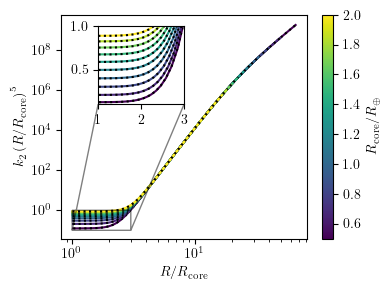

In [ ]:
norm = mcolors.Normalize(vmin=min_core_radius/R_earth, vmax=max_core_radius/R_earth)
cmap = cm.viridis
fig, ax = plt.subplots(figsize=(4,3))
axins = ax.inset_axes([0.15,0.6,0.35,0.35], xlim=(1e0,3e0), ylim=(1e-1,1e0))
for i,core_radius in enumerate(core_radii):
    ax.plot(data[i]["radius"]/core_radius, data[i]["k2"]*(data[i]["radius"]/core_radius)**5, color=cmap(norm(core_radius/R_earth)))

    k2_core = get_k2_core(core_radius, mu_core, rho_core)
    fit_func = lambda x,x1,x2,b1,b2: log_k2_func(x,k2_core,x1,x2,b1,b2)
    popt, pcov = curve_fit(fit_func, data[i]["radius"]/core_radius, np.log(data[i]["k2"]*(data[i]["radius"]/core_radius)**5), p0=[3.37, 20, 10, 2])
    ax.plot(data[i]["radius"]/core_radius, k2_func(data[i]["radius"]/core_radius,k2_core,*popt), linestyle="dotted", color="black")

    axins.plot(data[i]["radius"]/core_radius, data[i]["k2"]*(data[i]["radius"]/core_radius)**5, color=cmap(norm(core_radius/R_earth)))
    axins.plot(data[i]["radius"]/core_radius, k2_func(data[i]["radius"]/core_radius,k2_core,*popt), linestyle="dotted", color="black")

ax.indicate_inset_zoom(axins, edgecolor="black")
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(r"$R_\mathrm{core}/R_\oplus$")

ax.set_xlabel("$R/R_\\mathrm{core}$")
ax.set_ylabel("$k_2\\left(R/R_\\mathrm{core}\\right)^5$")
ax.set_xscale("log")
ax.set_yscale("log")
#ax.set_xlim(1,4)
#ax.set_ylim(1e-1,1e0)
fig.tight_layout()
fig.savefig("figures/k2R5_vs_R_Rcore.png", dpi=300)
plt.show()

/tmp/ipykernel_7632/4227350687.py:30: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(right=0.75)


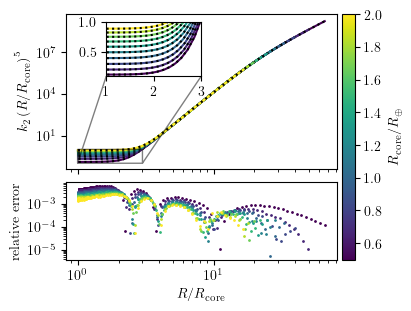

In [126]:
norm = mcolors.Normalize(vmin=min_core_radius/R_earth, vmax=max_core_radius/R_earth)
cmap = cm.viridis
fig, (ax,err_ax) = plt.subplots(figsize=(4,3), nrows=2, sharex=True, height_ratios=(2,1), constrained_layout=True)
axins = ax.inset_axes([0.15,0.6,0.35,0.35], xlim=(1e0,3e0), ylim=(1e-1,1e0))
for i,core_radius in enumerate(core_radii):
    ax.plot(data[i]["radius"]/core_radius, data[i]["k2"]*(data[i]["radius"]/core_radius)**5, color=cmap(norm(core_radius/R_earth)))

    k2_core = get_k2_core(core_radius, mu_core, rho_core)
    fit_func = lambda x,x1,x2,b1,b2: log_k2_func(x,k2_core,x1,x2,b1,b2)
    popt, pcov = curve_fit(fit_func, data[i]["radius"]/core_radius, np.log(data[i]["k2"]*(data[i]["radius"]/core_radius)**5), p0=[3.37, 20, 10, 2])
    ax.plot(data[i]["radius"]/core_radius, k2_func(data[i]["radius"]/core_radius,k2_core,*popt), linestyle="dotted", color="black")

    axins.plot(data[i]["radius"]/core_radius, data[i]["k2"]*(data[i]["radius"]/core_radius)**5, color=cmap(norm(core_radius/R_earth)))
    axins.plot(data[i]["radius"]/core_radius, k2_func(data[i]["radius"]/core_radius,k2_core,*popt), linestyle="dotted", color="black")

    err_ax.scatter(data[i]["radius"]/core_radius, np.abs((data[i]["k2"]*(data[i]["radius"]/core_radius)**5-k2_func(data[i]["radius"]/core_radius,k2_core,*popt))/(data[i]["k2"]*(data[i]["radius"]/core_radius)**5)), s=1, color=cmap(norm(core_radius/R_earth)))

ax.indicate_inset_zoom(axins, edgecolor="black")
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=[ax,err_ax], location="right", pad=0.02)
cbar.set_label(r"$R_\mathrm{core}/R_\oplus$")

err_ax.set_xlabel("$R/R_\\mathrm{core}$")
ax.set_ylabel("$k_2\\left(R/R_\\mathrm{core}\\right)^5$")
ax.set_xscale("log")
ax.set_yscale("log")
err_ax.set_xscale("log")
err_ax.set_yscale("log")
err_ax.set_ylabel("relative error")
fig.subplots_adjust(right=0.75)
#fig.tight_layout()
fig.savefig("figures/report/fit_multiple.pdf", dpi=300)
plt.show()

### Varying $\rho_\mathrm{core}$

In [36]:
R_core = R_earth
rho_atm = rho_air
mu_core = rigidity_earth
eta_core = viscosity_earth

no_atm_radii = 100
max_atm_radius = R_jupiter*3

no_rho_core = 10
min_rho_core = rho_earth/10
max_rho_core = rho_earth
rho_cores = np.linspace(min_rho_core, max_rho_core, no_rho_core)

data = []

rerun_sim = False
data_file = "varying_core_density"
data = np.load("data/"+data_file+".npz", allow_pickle=True)
data = data["data"]

/tmp/ipykernel_7632/812625111.py:7: RuntimeWarning: invalid value encountered in log
  return np.log(k2_func(x, k2_core, x1, x2, b1, b2))


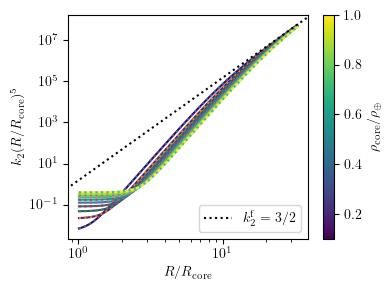

In [44]:
norm = mcolors.Normalize(vmin=min_rho_core/rho_earth, vmax=max_rho_core/rho_earth)
cmap = cm.viridis

fig, (ax) = plt.subplots(figsize=(4,3))
for i in range(no_rho_core):
    ax.plot(data[i]["radius"]/R_core, data[i]["k2"]*(data[i]["radius"]/R_core)**5, color=cmap(norm(rho_cores[i]/rho_earth)))
    k2_core = get_k2_core(R_core, mu_core, rho_cores[i])
    fit_func = lambda x,x1,x2,b1,b2: log_k2_func(x,k2_core,x1,x2,b1,b2)
    popt, pcov = curve_fit(fit_func, data[i]["radius"]/R_core, np.log(data[i]["k2"]*(data[i]["radius"]/R_core)**5), p0=[3.37, 20, 10, 2])
    ax.plot(data[i]["radius"]/R_core, k2_func(data[i]["radius"]/R_core,k2_core,*popt), linestyle="dotted")
    
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label(r"$\rho_\mathrm{core}/\rho_\oplus$")

R_interp = np.logspace(-1, 2, 100)
ax.plot(R_interp, 3/2*(R_core/R_interp/R_core)**-5, color="black", linestyle="dotted", label=r"$k_2^\mathrm{f}=3/2$")
#ax.axhline(get_k2_core(R_core, mu_core, rho_core), color="black", linestyle="--", label=r"$k_2^\mathrm{core}$")

ax.set_xlim(0.8494244773756144, 39.13117803315659)
ax.set_ylim(0.0022225180403935164, 175059812.96411967)

ax.set_xlabel(r"$R/R_\mathrm{core}$")
ax.set_ylabel(r"$k_2(R/R_\mathrm{core})^5$")
ax.set_xscale("log")
ax.set_yscale("log")

ax.legend(loc="lower right")
fig.tight_layout()
fig.savefig("figures/report/varying_rho_core_k2R5.pdf")
plt.show()
